# Speaker Diarization with Zero shot Speaker Identification

We will look into a simple speech pipeline to do speaker identification for speaker diarization, and ElasticSearch Malaysia-AI as vector database to store speaker vectors.

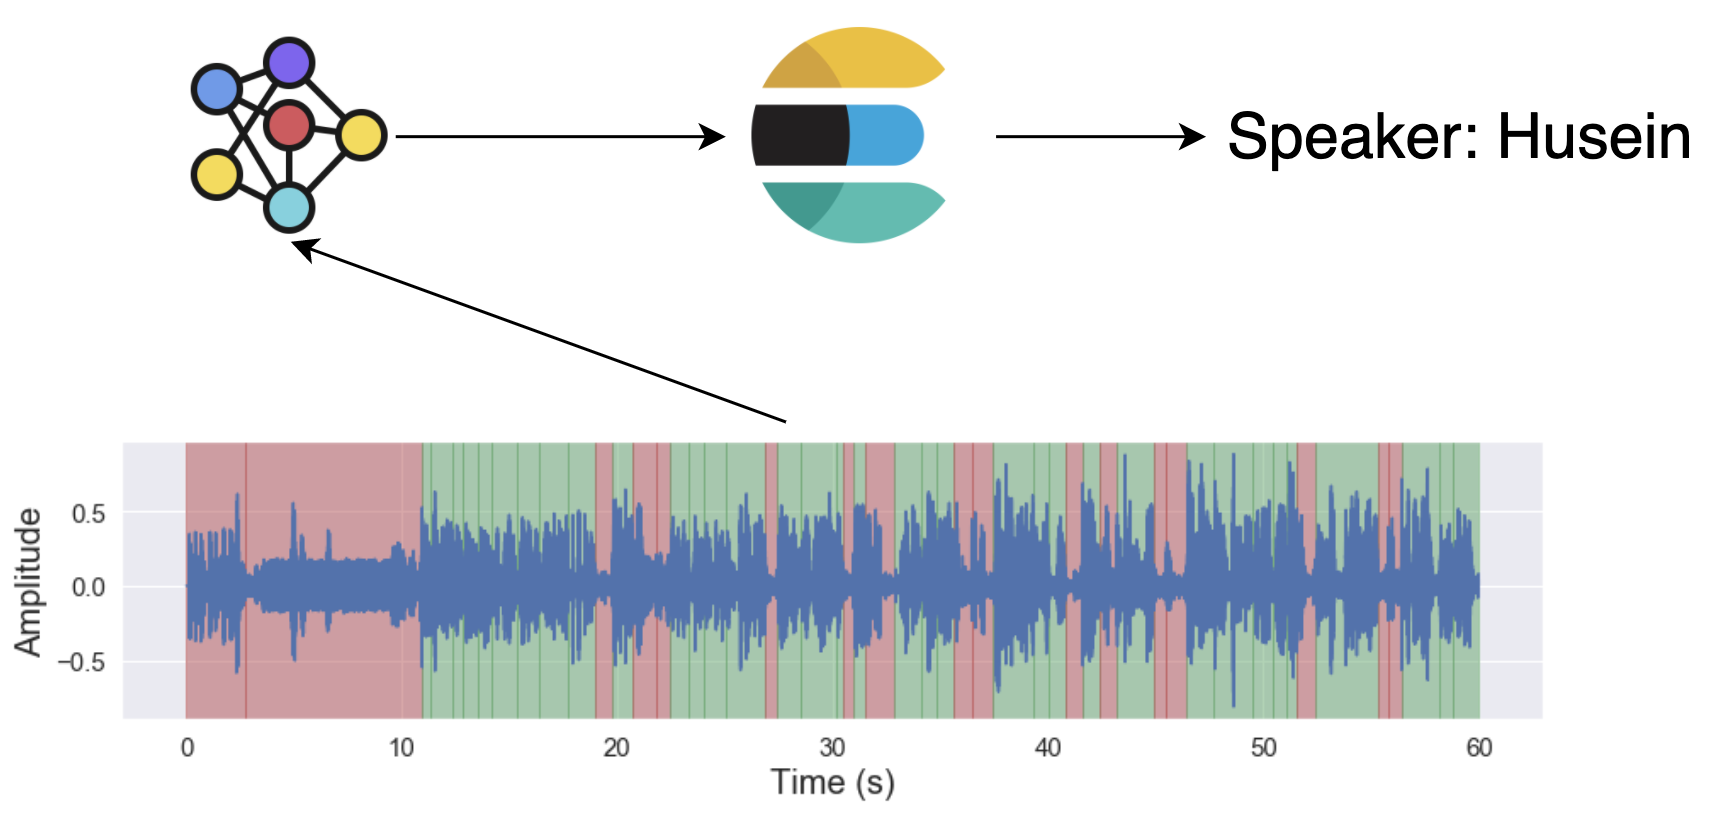

In [2]:
from IPython.core.display import Image, display

display(Image('artifacts/simple-es.png', width=600))

## Install necessary libraries

For speech toolkit, I am going to use https://malaya-speech.readthedocs.io to help me for Speaker Diarization and Speaker Identification.

```bash
pip install malaya-speech elasticsearch pycookiecheat requests
```

## Make sure we are connected to ElasticSearch Malaysia-AI

If you are part of Malaysia-AI, you can query ElasticSearch Malaysia-AI from anywhere!

Before that, we must login to https://elasticsearch.malaysiaai.ml using Chrome first.

In [1]:
from pycookiecheat import chrome_cookies
from elasticsearch import Elasticsearch
import requests

In [2]:
url = 'https://elasticsearch.malaysiaai.ml'
cookies = chrome_cookies(url)

In [3]:
requests.get(url, cookies = cookies).json()

{'name': 'malaysia-ai',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'B2YuhAj3T9i2KXnBbAc1uA',
 'version': {'number': '7.15.0',
  'build_flavor': 'default',
  'build_type': 'deb',
  'build_hash': '79d65f6e357953a5b3cbcc5e2c7c21073d89aa29',
  'build_date': '2021-09-16T03:05:29.143308416Z',
  'build_snapshot': False,
  'lucene_version': '8.9.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [4]:
cookie_string = []
for k, v in cookies.items():
    cookie_string.append(f'{k}={v}')
cookie_string = '; '.join(cookie_string)

es = Elasticsearch(hosts = [url], headers = {'Cookie': cookie_string})
resp = es.info()
resp

{'name': 'malaysia-ai',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'B2YuhAj3T9i2KXnBbAc1uA',
 'version': {'number': '7.15.0',
  'build_flavor': 'default',
  'build_type': 'deb',
  'build_hash': '79d65f6e357953a5b3cbcc5e2c7c21073d89aa29',
  'build_date': '2021-09-16T03:05:29.143308416Z',
  'build_snapshot': False,
  'lucene_version': '8.9.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

Good to go!

## Load example speakers

I have a few audios, each presented a unique speaker.

In [5]:
import malaya_speech
import matplotlib.pyplot as plt
from glob import glob
import os

audios = glob('artifacts/*.wav')
audios

['artifacts/haqkiem.wav',
 'artifacts/khalil-nooh.wav',
 'artifacts/mas-aisyah.wav',
 'artifacts/female.wav',
 'artifacts/shafiqah-idayu.wav',
 'artifacts/husein-zolkepli.wav']

In [6]:
os.path.split(audios[0])[1]

'haqkiem.wav'

In [7]:
sr = 16000

Y, speakers = [], []
for a in audios:
    speaker = os.path.split(a)[1].replace('.wav', '')
    y, _ = malaya_speech.load(a, sr = sr)
    Y.append(y)
    speakers.append(speaker)

## Convert audios into represent vector

We can use any speaker vector models available on the internet, but in this notebook, I am going to use model from https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html 

In [8]:
malaya_speech.speaker_vector.available_model()

INFO:root:tested on VoxCeleb2 test set. Lower EER is better.


,Size (MB),Quantized Size (MB),Embedding Size,EER
deep-speaker,96.7,24.40,512.0,0.21870
vggvox-v1,70.8,17.70,1024.0,0.14070
vggvox-v2,43.2,7.92,512.0,0.04450
speakernet,35.0,8.88,7205.0,0.02122


I am going to load `vggvox-v2` model, embedding size just 512, nice to store in a small ElasticSearch.

In [9]:
model = malaya_speech.speaker_vector.deep_model('vggvox-v2')

INFO:root:running speaker-vector/vggvox-v2 using device /device:CPU:0


Let's we visualize one sample audio,

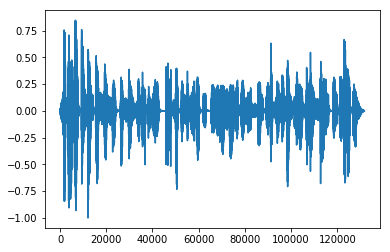

In [10]:
plt.plot(Y[0])
plt.show()

And the length of this sample is,

In [11]:
len(Y[0]) / 16000

8.2314375

8 seconds, pretty long to feed into speaker vector model. Yes, we can feed directly to the model, but it is better we chunk the sample into multiple samples to get different speaker vectors. To chunk it, we can use Voice Activity Detection module to only sample positive voice activities.

## Chunks using VAD

I am going to use WebRTC for our VAD model, malaya-speech also provided deep learning model for better VAD, https://malaya-speech.readthedocs.io/en/latest/load-vad.html, but for this example, we keep it simple.

```bash
pip install webrtcvad
```

malaya-speech provided simple interface for webRTC.

In [12]:
vad = malaya_speech.vad.webrtc()

### How to detect Voice Activity

In order to use available Malaya-Speech VAD models, we need to split our audio sample into really small chunks.

For Google WebRTC, we need to split by every 30 ms and the frame must be in integer format. For deep learning, we trained on 30 ms, 90 ms and random length less than 300 ms.

To split an audio sample by giving time split, use, [malaya_speech.utils.generator.frames](https://github.com/huseinzol05/malaya-speech/blob/master/malaya_speech/utils/generator.py#L7).

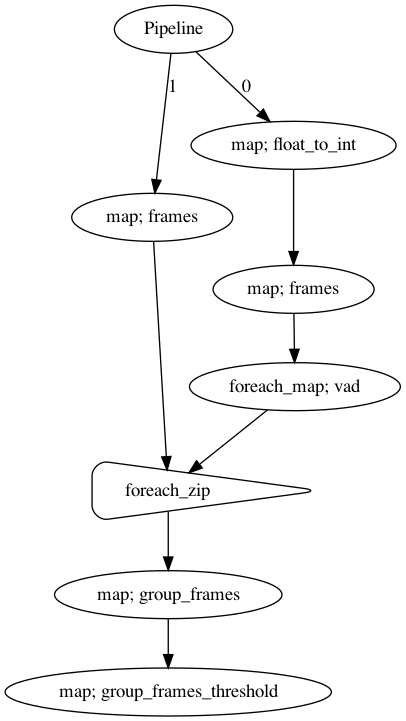

In [13]:
from malaya_speech import Pipeline

p = Pipeline()
to_int = p.map(malaya_speech.utils.astype.float_to_int)
int_frames = to_int.map(malaya_speech.utils.generator.frames, append_ending_trail = False)
float_frames = p.map(malaya_speech.utils.generator.frames, append_ending_trail = False)
vad_map = int_frames.foreach_map(vad)
foreach = float_frames.foreach_zip(vad_map)
foreach.map(malaya_speech.utils.group.group_frames)\
.map(malaya_speech.utils.group.group_frames_threshold, threshold_to_stop = 0.1)
p.visualize()

malaya-speech provided a simple pipeline to combine multiple callables into a single pipeline, https://malaya-speech.readthedocs.io/en/latest/load-pipeline.html

The pipeline is simple,

audio -> cast float to integer -> split the audio into 30 ms small chunks -> for each 30 ms small chunks will feed into WebRTC -> combine result -> group similar VAD labels into 1 longer sample -> merged multiple different VAD labels if threshold below 0.05 seconds.

In [14]:
%%time

result = p(Y[0])
result.keys()

CPU times: user 30.5 ms, sys: 2.93 ms, total: 33.4 ms
Wall time: 32.2 ms


dict_keys(['float_to_int', 'frames', 'vad', 'foreach_zip', 'group_frames', 'group_frames_threshold'])

In [15]:
result['group_frames_threshold'][:5]

[(<malaya_speech.model.frame.Frame at 0x14d1180d0>, True),
 (<malaya_speech.model.frame.Frame at 0x14d118090>, True),
 (<malaya_speech.model.frame.Frame at 0x14d118050>, True),
 (<malaya_speech.model.frame.Frame at 0x14d101f90>, True),
 (<malaya_speech.model.frame.Frame at 0x14d101fd0>, True)]

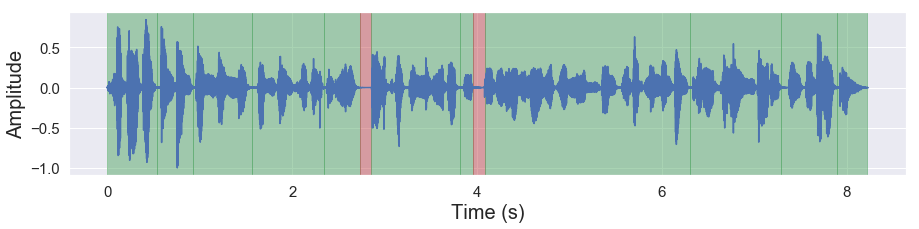

In [16]:
malaya_speech.extra.visualization.visualize_vad(Y[0], result['group_frames_threshold'], sr)

In [17]:
import IPython.display as ipd

ipd.Audio(result['group_frames_threshold'][0][0].array, rate = sr)

In [18]:
ipd.Audio(result['group_frames_threshold'][1][0].array, rate = sr)

In [19]:
ipd.Audio(result['group_frames_threshold'][2][0].array, rate = sr)

In [20]:
ipd.Audio(result['group_frames_threshold'][3][0].array, rate = sr)

## Apply VAD after that feed into speaker models

In [21]:
vectors = []
for i in range(len(Y)):
    result = p(Y[i])
    for r in result['group_frames_threshold']:
        if r[1]:
            vectors.append((model([r[0]])[0], speakers[i]))
            
len(vectors)

25

In [22]:
vectors, speakers = list(zip(*vectors))

## Visualize in lower dimension

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
components = pca.fit_transform(vectors)

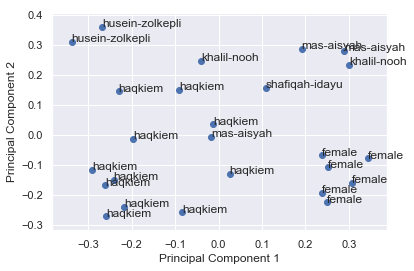

In [24]:
fig, ax = plt.subplots()
ax.scatter(components[:, 0], components[:, 1])

for i, speaker in enumerate(speakers):
    ax.annotate(speaker, (components[i, 0], components[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Insert vectors into ElasticSearch

First, we need to define index mapping about the vectors,

In [25]:
MAPPING_DEALS = {
    'mappings': {
        'properties': {
            'vector': {'type': 'dense_vector', 'dims': vectors[0].shape[0]},
        }
    },
}

In [26]:
index = 'test-speaker'
es.indices.delete(index = index, ignore = [400, 404])
es.indices.create(index = index, body = MAPPING_DEALS)

INFO:elasticsearch:DELETE https://elasticsearch.malaysiaai.ml:443/test-speaker [status:200 request:0.094s]
INFO:elasticsearch:PUT https://elasticsearch.malaysiaai.ml:443/test-speaker [status:200 request:0.178s]


{'acknowledged': True, 'shards_acknowledged': True, 'index': 'test-speaker'}

In [27]:
from tqdm import tqdm

# to speed up, you might want to use bulk insert
for i in tqdm(range(len(vectors))):
    es.index(index = index, doc_type = '_doc',
             body= {'vector': vectors[i].tolist(), 'speaker': speakers[i]})

  4%|▍         | 1/25 [00:00<00:02,  9.26it/s]INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:201 request:0.045s]
 16%|█▌        | 4/25 [00:00<00:01, 11.11it/s]INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:201 request:0.042s]
 28%|██▊       | 7/25 [00:00<00:01, 12.99it/s]INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://elasticsearch.malaysiaai.ml:443/test-speaker/_doc [status:20

### Sort based on cosine similarity from ElasticSearch

ElasticSearch support cosine similarity sorting, read more at https://www.elastic.co/blog/text-similarity-search-with-vectors-in-elasticsearch

In [28]:
data = {
    'query': {
        'script_score': {
            'query': {'match_all': {}},
            'script': {
                'source': "(cosineSimilarity(params.query_vector, 'vector'))",
                'params': {'query_vector': vectors[0].tolist()},
            },
        }
    },
    'size': 2,
    '_source': ['speaker']
}
url_index = f'{url}/{index}/_search'
r = requests.post(url_index, json = data, cookies = cookies).json()
r

{'took': 13,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 17, 'relation': 'eq'},
  'max_score': 0.99999994,
  'hits': [{'_index': 'test-speaker',
    '_type': '_doc',
    '_id': 'p8yrJ3wBXDIj-_AAmIBw',
    '_score': 0.99999994,
    '_source': {'speaker': 'haqkiem'}},
   {'_index': 'test-speaker',
    '_type': '_doc',
    '_id': 'r8yrJ3wBXDIj-_AAmoAU',
    '_score': 0.82846445,
    '_source': {'speaker': 'haqkiem'}}]}}

## Now, speaker diarization

Let say I have an audio with multiple speakers in it, I want to diarize it and identify each speakers, to read more about speaker diarization at https://malaya-speech.readthedocs.io/en/latest/load-diarization.html

In [29]:
from pydub import AudioSegment
import numpy as np

audio = AudioSegment.from_file('artifacts/husein-ayu.m4a')
samples = np.array(audio.get_array_of_samples())
samples = malaya_speech.astype.int_to_float(samples)
samples = malaya_speech.resample(samples, audio.frame_rate, 16000)

In [30]:
audio

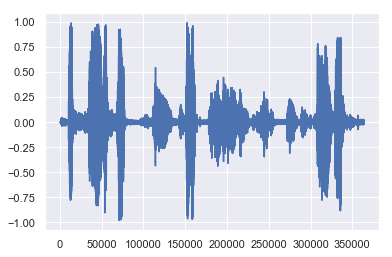

In [31]:
plt.plot(samples)

To do speaker diarization, we need to VAD -> group VAD -> Populate positive VAD -> clustering.

In [32]:
%%time

result = p(samples)
result.keys()

CPU times: user 196 ms, sys: 27.3 ms, total: 224 ms
Wall time: 82.2 ms


dict_keys(['float_to_int', 'frames', 'vad', 'foreach_zip', 'group_frames', 'group_frames_threshold'])

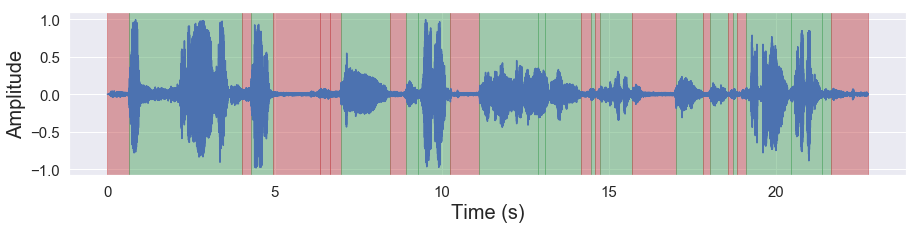

In [33]:
malaya_speech.extra.visualization.visualize_vad(samples, result['group_frames_threshold'], sr)

In [52]:
result_diarization_sc = malaya_speech.diarization.spectral_cluster(result['group_frames_threshold'], 
                                                                              model,
                                                                             min_clusters = 2,
                                                                             max_clusters = 100)
result_diarization_sc[:20]

[(<malaya_speech.model.frame.Frame at 0x14e0ea610>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x14e0ea350>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x14e0ea650>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x15c9ecc10>, 'speaker 2'),
 (<malaya_speech.model.frame.Frame at 0x14e0f7c50>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x14e0f7510>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x14e0f7190>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x14e0f7f90>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x14e0f70d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x14e0f72d0>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x14e0f7290>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x14e0f75d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x14e0fab90>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x14e0fa7d0>, 'speaker 3'),
 (<malaya_speech.model.frame.Frame at 0x14e0fa99

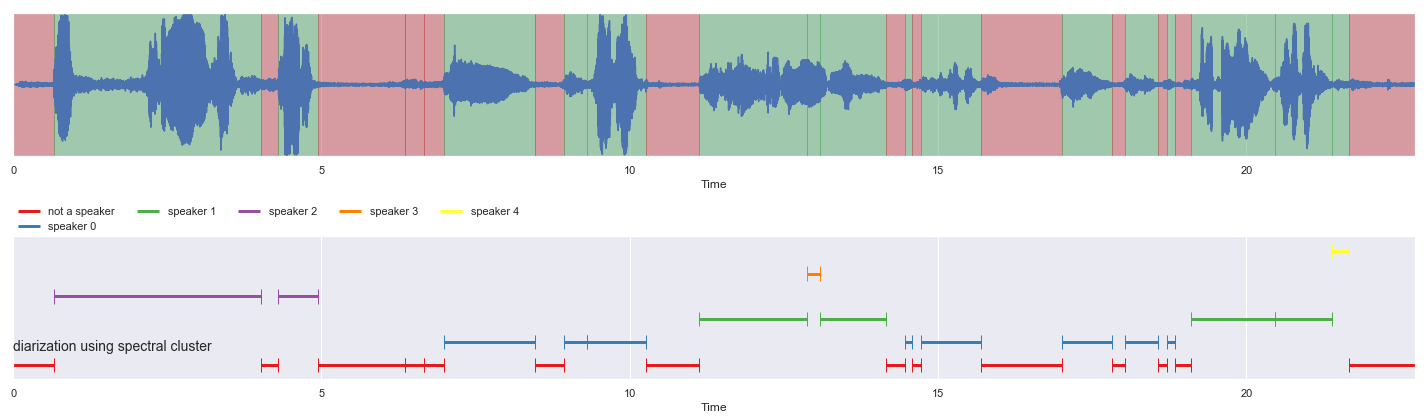

In [53]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(samples, result['group_frames_threshold'], sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_sc,
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

In [39]:
ipd.Audio(result_diarization_sc[1][0].array, rate = sr)

In [41]:
ipd.Audio(result_diarization_sc[3][0].array, rate = sr)

In [43]:
ipd.Audio(result_diarization_sc[7][0].array, rate = sr)

In [56]:
ipd.Audio(result_diarization_sc[12][0].array, rate = sr)

### Now, who is the speaker for result_diarization_sc[1]?

In [60]:
v = model([result_diarization_sc[1][0].array])[0]
data = {
    'query': {
        'script_score': {
            'query': {'match_all': {}},
            'script': {
                'source': "(cosineSimilarity(params.query_vector, 'vector'))",
                'params': {'query_vector': v.tolist()},
            },
        }
    },
    'size': 1,
    '_source': ['speaker']
}
url_index = f'{url}/{index}/_search'
r = requests.post(url_index, json = data, cookies = cookies).json()
r

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 25, 'relation': 'eq'},
  'max_score': 0.8808331,
  'hits': [{'_index': 'test-speaker',
    '_type': '_doc',
    '_id': 'vsyrJ3wBXDIj-_AAnIDX',
    '_score': 0.8808331,
    '_source': {'speaker': 'husein-zolkepli'}}]}}

### Now, who is the speaker for result_diarization_sc[12]?

In [61]:
v = model([result_diarization_sc[12][0].array])[0]
data = {
    'query': {
        'script_score': {
            'query': {'match_all': {}},
            'script': {
                'source': "(cosineSimilarity(params.query_vector, 'vector'))",
                'params': {'query_vector': v.tolist()},
            },
        }
    },
    'size': 1,
    '_source': ['speaker']
}
url_index = f'{url}/{index}/_search'
r = requests.post(url_index, json = data, cookies = cookies).json()
r

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 25, 'relation': 'eq'},
  'max_score': 0.8343149,
  'hits': [{'_index': 'test-speaker',
    '_type': '_doc',
    '_id': 'vcyrJ3wBXDIj-_AAnICn',
    '_score': 0.8343149,
    '_source': {'speaker': 'shafiqah-idayu'}}]}}